In [1]:
%cd ..

/home/fedora/Jupyter/river-profiles


In [2]:
import warnings

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Equations for the elevations
There is some analytical solution in the [article](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgrf.20031)
For the moment $\tau > \tau_i$, $\tau < \tau_{i+1}$ and
$$
\chi = n(\tau - \tau_i)\nu(\tau_i)^{(n-1)/n}
$$
the elevation:
$$
\lambda = (n-1)(\tau - \tau_i)\nu(\tau_i) + \int\limits_{\tau_i}^\tau \nu(\tau\prime) d\tau\prime
$$

## Understanding this formula
This should be an analytical solution of the equation
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$
where $\nu(\tau, \chi) = \nu(\tau)$ is a stair finction of $\tau$ which do not depend on $\chi$:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i \in \{1, ..., k\}\\
\nu_{k + 1},\; \tau > \tau_k
\end{cases}
$$

The equations like this have the [solution](https://eqworld.ipmnet.ru/en/solutions/fpde/fpde3302.pdf) like
$$
\lambda(\tau, \chi) = c_1\chi - c_1^n\tau + \int\limits_0^\tau \nu(t) dt + c_2
$$

We have a border constrain $\lambda(\tau, 0) = 0$, so we can conclude:
1. $\lambda(0, 0) = c_2 = 0$
2. $\lambda(\tau, 0) = -c_1^n\tau + \int\limits_0^\tau \nu(t) dt = 0$
$$
c_1^n\tau = \int\limits_0^\tau \nu(t) dt
$$
If we will take the derivative, we will get
$$
c_1^n = \nu(\tau)
$$
and so
$$
c_1 = (\nu(\tau))^{1/n}
$$
$$
\lambda(\tau, \chi) = (\nu(\tau))^{1/n}\chi - \nu(\tau)\tau + \int\limits_0^{\tau}\nu(t) dt
$$

Let $\tau_i \leq \tau < \tau_{i+1}$ and $\tau_0 = 0$. Then $\nu(\tau) = \nu_{i+1}$ and integral:
$$
\int\limits_0^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$
and the $\lambda$ will be
$$
\lambda(\tau, \chi) = (\nu_{i+1})^{1/n}\chi - \nu_{i+1}\tau + \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$


# Realization

## Stair function
The function $\nu$ should often look like:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i = 1, ..., k-1\\
\nu_k,\; \tau > \tau_k
\end{cases}
$$
And we are going to work with this case.

In [3]:
def lengths_check(borders, values, raise_error=True):
    # Returns True, if lengths are correct: borders array should contain 1 element less, than values array
    # If this is not correct, it will raise error if raise_error or return Flase in other case.
    r = len(values) - len(borders) == 1
    if raise_error and not r:
        msg = f'Wrong arrays lengths: borders array should contain 1 element less, than values array. But their length are {len(borders)} and {len(values)}.'
        raise ValueError(msg)
        
    borders = np.array(borders)
    if (borders[1:] - borders[:-1] <= 0).any():
        warnings.warn("The borders array is not strictly increasing")
    return r

In [4]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    lengths_check(borders, values, raise_error=True)
    x = np.array(x)
    if x.shape == ():
        r = values[0]*np.ones(1)
    else:
        r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    if x.shape == ():
        return r[0]
    return r

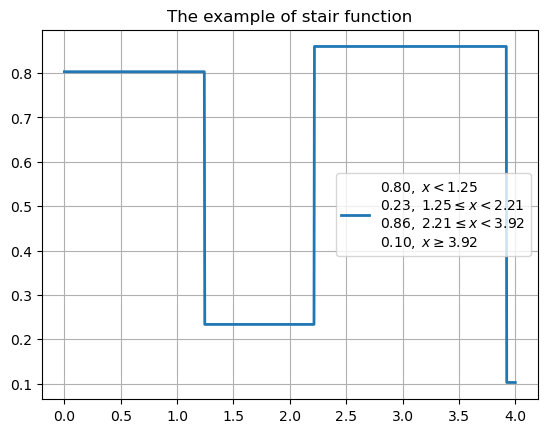

In [5]:
x0, x1 = 0, 4
n_stairs = 3
borders = x0 + (x1 - x0)*np.sort(np.random.random(n_stairs))
values = np.random.random(n_stairs + 1)

label = [r'${0:.2f}, \; {1:.2f} \leq x < {2:.2f}$'.format(values[i+1], 
                                                          borders[i], 
                                                          borders[i+1]) for i in range(n_stairs - 1)]
label = np.append(r'${0:.2f}, \; x < {1:.2f}$'.format(values[0], borders[0]), label)
label = np.append(label, r'${0:.2f}, \; x \geq {1:.2f}$'.format(values[-1], borders[-1]))
label = '\n'.join(label)

x = np.linspace(x0, x1, 1000)
y = stair_function(x, borders=borders, values=values)

plt.title('The example of stair function')
plt.plot(x, y, linewidth=2, label=label)
plt.legend()
plt.grid(True)
plt.show()

In [6]:
stair_function(4, borders=borders, values=values)

0.10254356610945137

## Integral of stair function

For $\tau$ such that $\tau_i \leq \tau < \tau_{i+1}$ the integral of stair function $\nu$ will be:
$$
\int\limits_{\tau_0}^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$

In [7]:
def step_integral(x, x0=0, borders=[], values=[0], negative_backward=True):
    """
    Returns 
    """
    lengths_check(borders, values, raise_error=True)
    
    x1 = np.array(x)
    x0 = x0*np.ones(x1.shape)
    
    borders_ = np.concatenate([[-np.inf], borders, [+np.inf]])
    
    ones = np.ones(np.append(len(borders_), x1.shape).astype(int))
    res = ones*borders_.reshape(np.append(len(borders_), np.ones(len(x1.shape))).astype(int))
    res[res < x0] = (x0*ones)[res < x0]
    res[res > x1] = (x1*ones)[res > x1]
    res = res[1:] - res[:-1]
    res = res*np.array(values).reshape(np.append(len(values), np.ones(len(res.shape) - 1)).astype(int))
    res = res.sum(axis=0)
    
    if negative_backward and (x0 > x1).any():
        res[x0 > x1] = -step_integral(x=x0[x0 > x1], x0=x1[x0 > x1], borders=borders, values=values)
    
    return res

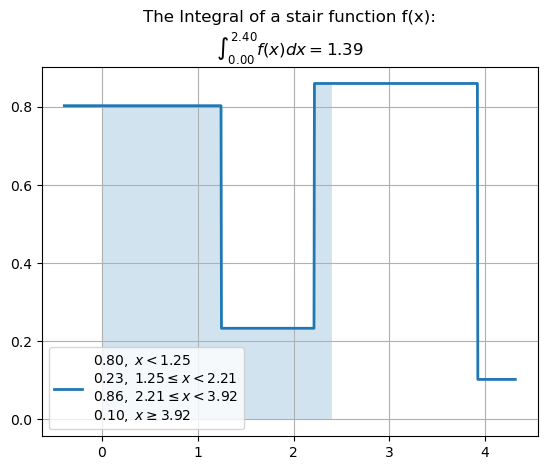

In [8]:
x0, x1 = 0, 2.4
int_val = step_integral(x1, x0, borders=borders, values=values)

xl = np.append(x0, borders).min()
xr = np.append(x1, borders).max()
xl, xr = xl - 0.1*(xr - xl), xr + 0.1*(xr - xl)

x = np.linspace(xl, xr, 1000)
y = stair_function(x, borders=borders, values=values)

x_int = np.linspace(x0, x1, 1000)
y_int = stair_function(x_int, borders=borders, values=values)

title = 'The Integral of a stair function f(x):\n' 
title += r'$\int_{{{0:.2f}}}^{{{1:.2f}}} f(x) dx = {2:.2f}$'.format(x0, x1, int_val)

plt.title(title)
plt.plot(x, y, linewidth=2, label=label)
plt.fill_between(x_int, y_int, alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

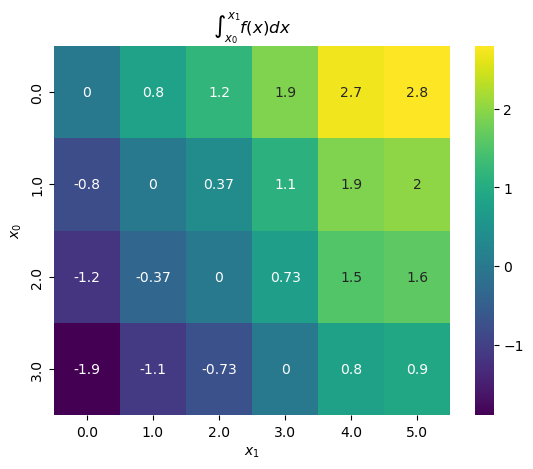

In [9]:
n = 4
m = 6
x0 = np.arange(n).reshape([n, 1])*np.ones([n, m])
x1 = np.arange(m).reshape([1, m])*np.ones([n, m])

int_vals = step_integral(x1, x0, borders=borders, values=values)

plt.title(r'$\int_{x_0}^{x_1} f(x) dx$')
sns.heatmap(pd.DataFrame(int_vals, 
                         columns=pd.Index(x1[0], name='$x_1$'), 
                         index=pd.Index(x0[:, 0], name='$x_0$')), 
            annot=True, cmap='viridis')
plt.show()

## $\chi$-invariant Elevation
$$
\lambda(\tau, \chi) = (\nu(\tau))^{1/n}\chi - \nu(\tau)\tau + \int\limits_0^{\tau}\nu(t) dt
$$

In [10]:
def elevation(tau, chi, n, borders=[], values=[0]):
    """
    """
    nu_val = stair_function(tau, borders, values)
    res = nu_val**(1/n)*chi - nu_val*tau + step_integral(x=chi, x0=0, borders=borders, values=values)
    return res

/tmp/ipykernel_9722/3508793855.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


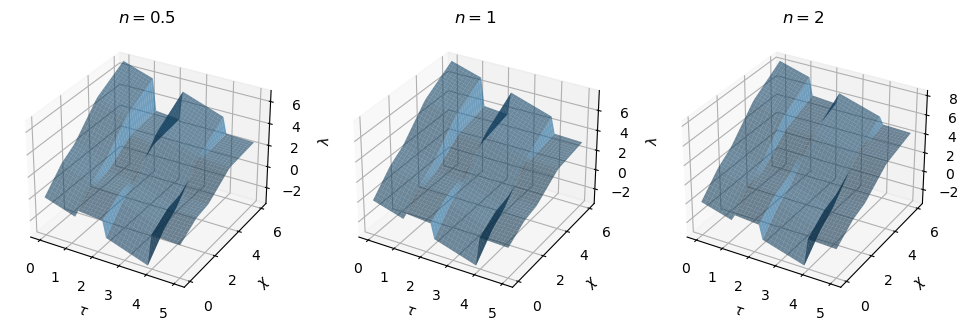

In [11]:
tau = np.linspace(0, 5, 40)
chi = np.linspace(0, 6, 40)

ns = [0.5, 1, 2]

taus = np.ones([len(tau), len(chi)])*tau.reshape([len(tau), 1])
chis = np.ones([len(tau), len(chi)])*chi.reshape([1, len(chi)])

fig, axs = plt.subplots(1, len(ns), subplot_kw={"projection": "3d"})

fig.set_figheight(6)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    sols = elevation(taus, chis, n, borders=borders, values=values)
    
    axs[i].set_title(f'$n = {n}$')
    axs[i].plot_surface(taus, chis, sols, alpha=0.6)
    axs[i].set_xlabel(r'$\tau$')
    axs[i].set_ylabel(r'$\chi$')
    axs[i].set_zlabel(r'$\lambda$')

fig.show()

In [12]:
def get_lower(x, borders=[]):
    # 
    x = np.array(x)
    borders_ = np.array(borders)
    borders_ = np.ones(np.append(x.shape, len(borders_))) * borders_
    borders_[borders_ > x.reshape(np.append(x.shape, 1))] = -np.inf
    borders_ = borders_.max(axis=-1)
    return borders_

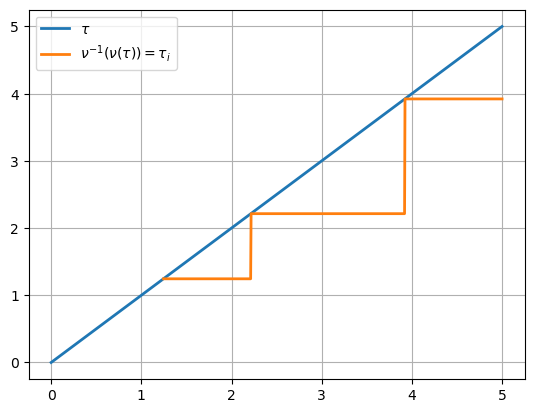

In [13]:
taus = np.linspace(0, 5, 1000)

plt.plot(taus, taus, linewidth=2, label=r'$\tau$')
plt.plot(taus, get_lower(taus, borders), linewidth=2, label=r'$\nu^{-1}(\nu(\tau)) = \tau_i$')

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_9722/4165798217.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


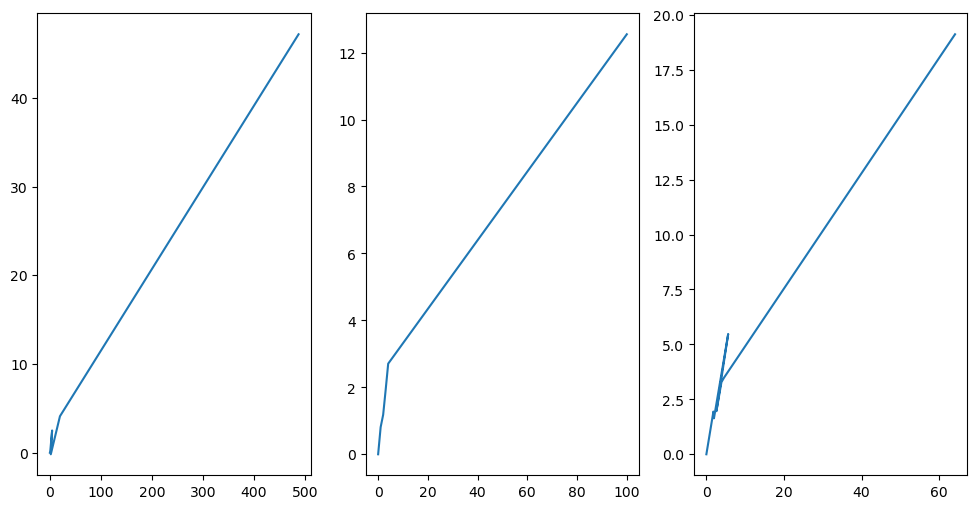

In [14]:
taus = np.linspace(0, 100, 100)

ns = [0.5, 1, 2]

fig, axs = plt.subplots(1, len(ns))

fig.set_figheight(6)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    tau_i = get_lower(taus, borders=borders)
    tau_i[tau_i < 0] = 0
    chis = n*(taus)*stair_function(taus, borders=borders, values=values)**((n-1)/n)
    sols = elevation(taus, chis, n, borders=borders, values=values)
    axs[i].plot(chis, sols)

fig.show()

In [15]:
get_lower(taus, borders=borders)

array([      -inf,       -inf, 1.24511124, 2.21442336, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188372,
       3.92188372, 3.92188372, 3.92188372, 3.92188372, 3.92188

# Slope patches

$$
\chi = n(\tau - \tau_i)\nu(\tau_i)^{(n-1)/n}
$$
$$
\lambda = (n-1)(\tau - \tau_i)\nu(\tau_i) + \int\limits_{\tau_i}^\tau \nu(\tau\prime) d\tau\prime
$$

In [16]:
borders = [1, 2, 4, 5]
values = [1, 2, 0.5, 2, 1]

In [17]:
def lam_fun(tau, tau0, nu, n):
    try:
        return (n - 1)*(tau - tau0)*nu(tau) + sp.integrate.quad(nu, tau0, tau)[0]
    except ValueError:
        r = (n - 1)*(tau - tau0)*nu(tau)
        r += np.array([sp.integrate.quad(nu, tau0, tau_val)[0] for tau_val in tau])
        return r

In [18]:
def get_patch(tau0, nu, n=1, borders=[], values=[0]):
    # 
    chi = lambda tau: n*(tau - tau0)*nu(tau)**((n-1)/n) # По идее, так, но херня какая-то...
    #chi = lambda tau: n*(tau - 0   )*nu(tau)**((n-1)/n)
    #chi = lambda tau: n*(tau)*nu(tau)**((n-1)/n)
    #lam = lambda tau: (n - 1)*(tau - tau0)*nu(tau)# + nu(tau0*np.ones(tau.shape))*(tau - tau0)
    lam = lambda tau: (n - 1)*(tau - tau0)*nu(tau) + step_integral(tau, 0, borders=borders, values=values)
    #lam = lambda tau: (n - 1)*(tau - tau0)*nu(tau) + sp.integrate.quad(nu, tau0, tau)[0]
    #lam = lambda tau: lam_fun(tau, tau0, nu, n)
    return chi, lam

In [19]:
def get_patches(borders, values, nu=None, n=1):
    # 
    if nu is None:
        nu = lambda tau: stair_function(tau, borders, values)
    lengths_check(borders, values)
    
    res = []
    for i in range(len(borders) - 1):
        tau0, tau1 = borders[i], borders[i+1]
        chi, lam = get_patch(tau0, nu, n=n, borders=borders, values=values)
        #start = get_patch_start(tau, 0, nu_start, n=1)
        res.append({'tau0': tau0, 
                    'tau1': tau1, 
                    'chi': chi, 
                    'lam': lam})
    return res

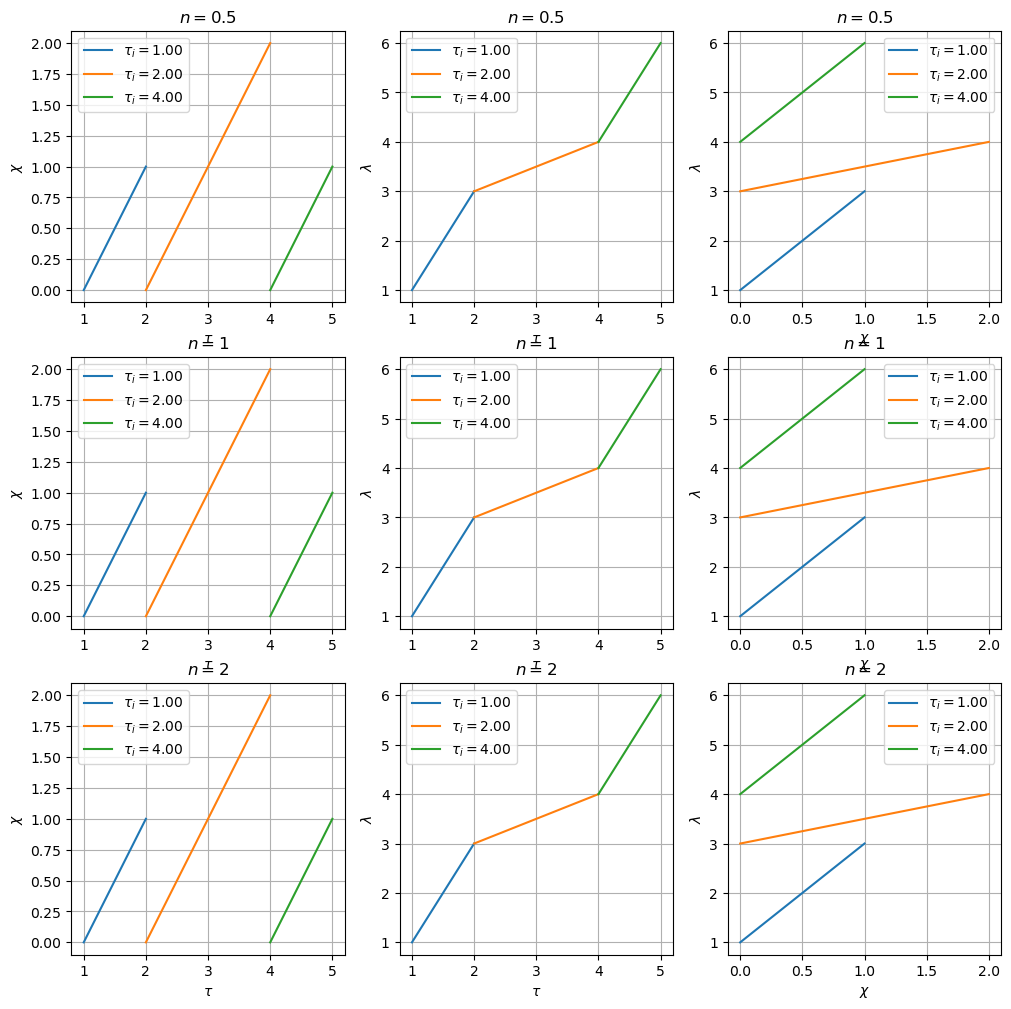

In [20]:
ns = [0.5, 1, 2]

fig, axs = plt.subplots(len(ns), 3)


fig.set_figheight(12)
fig.set_figwidth(12)

for i, n in enumerate(ns):
    for d in get_patches(borders, values):
        tau = np.linspace(d['tau0'], d['tau1'], 100)
        chi = d['chi'](tau)
        lam = d['lam'](tau)
        axs[i, 0].set_xlabel(r'$\tau$')
        axs[i, 0].set_ylabel(r'$\chi$')
        axs[i, 0].plot(tau, chi, label=r'$\tau_i = {0:.2f}$'.format(d['tau0']))
        
        axs[i, 1].set_xlabel(r'$\tau$')
        axs[i, 1].set_ylabel(r'$\lambda$')
        axs[i, 1].plot(tau, lam, label=r'$\tau_i = {0:.2f}$'.format(d['tau0']))
        
        axs[i, 2].set_xlabel(r'$\chi$')
        axs[i, 2].set_ylabel(r'$\lambda$')
        axs[i, 2].plot(chi, lam, label=r'$\tau_i = {0:.2f}$'.format(d['tau0']))
        
    for j in range(3):
        axs[i, j].set_title(f'$n = {n}$')
        axs[i, j].legend()
        axs[i, j].grid(True)
plt.show()

Equations 16:
$$
\lambda =
\begin{cases}
\chi\nu_1^{1/n} + (\tau - \tau_2)(\nu_2 - \nu_1), \; \tau_i \le \tau_2;\; \chi \ge\chi_1 \\
\cfrac{n-1}{n}(\cfrac{\chi^n}{n(\tau - \tau_2})^{\cfrac{1}{n-1}} + (\tau - \tau_2)\nu_2, \; \tau_i = \tau_2, \; \chi_1 < \chi < \chi_2 \\
\chi\nu_2^{1/n}, \;\; \tau_i \ge \tau_2; \; \chi \le \chi_2
\end{cases}
$$
with
$$
\chi_1 = n(\tau - \tau_2)\nu_1^{(n-1)/n}
$$
$$
\chi_2 = n(\tau - \tau_2)\nu_2^{(n-1)/n}
$$

So the $i$-th patch shoud start in
$$
\chi_{i, 0} = n(\tau - \tau_i)\nu_i^{(n-1)/n}
$$

In [21]:
ns = [0.5, 1, 2]

taus_i = [0, 1, 3, 5]
nus_i = [2, 0.5, 2, 0.5]

colors = ['blue', 'orange', 'green', 'red']

In [22]:
def get_patch_start(tau, tau_start, nu_val, n=1):
    # 
    chi = n*(tau - tau_start)*nu_val**((n - 1)/n)
    chi[chi < 0] = np.nan
    return chi

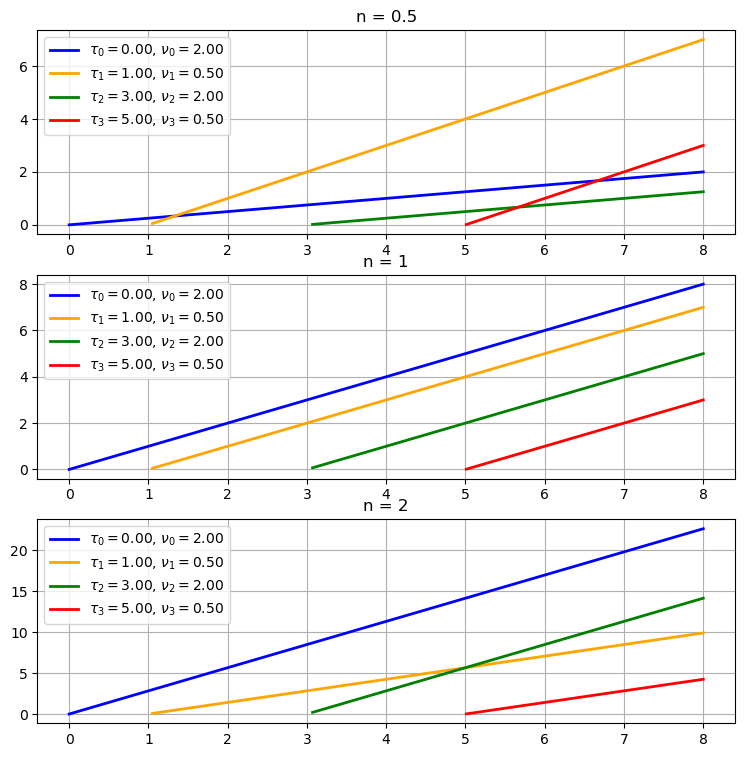

In [23]:
ns = [0.5, 1, 2]


fig, axs = plt.subplots(len(ns))


fig.set_figheight(9)
fig.set_figwidth(9)

taus = np.linspace(0, 8, 100)
for j, n in enumerate(ns):
    axs[j].set_title(f'n = {n}')
    for i in range(len(taus_i)):
        tau_i = taus_i[i]
        nu_i = nus_i[i]
        chis_start = get_patch_start(taus, tau_start=tau_i, nu_val=nu_i, n=n)
        label = '$\\tau_{0} = {1:.2f}$, $\\nu_{0} = {2:.2f}$'.format(i, tau_i, nu_i)
        #label = f'{i}-th slope pathes start\n' + label
        axs[j].plot(taus, chis_start, linewidth=2, color=colors[i],
                 label=label)

    axs[j].legend()
    axs[j].grid(True)
plt.show()

In [24]:
class SlopePatches:
    def __init__(self, patch_starts, uplift_rates, n, rate_before=0):
        """
        Parameters:
        -----------
        patch_starts - float array length N > 0
            The times tau_i, when i-th patch starts
        
        uplift_rates - float array length N
            The values nu_i, uplift rate of the i-th patch (correspondes tau between tau_i and tau_{i+1})
        
        n - float
            The exponent on channel slope
        
        rate_before - float
            The uplift rate for tau less than tau_0 = patch_starts[0]
        """
        if len(patch_starts) == 0:
            raise ValueError('The patch_starts should be not empty.')
        if len(uplift_rates) != len(uplift_rates):
            msg = 'The arrays patch_starts and uplift_rates should be the same length. But:'
            msg += f'\nlen(patch_starts) = {len(patch_starts)}\nlen(uplift_rates) = {len(uplift_rates)}'
            raise ValueError(msg)
            
        self.patch_starts = np.array(patch_starts)
        self.uplift_rates = np.array(uplift_rates)
        self.n = float(n)
        self.rate_before = float(rate_before)
    
    
    def get_uplift_rate(self, tau):
        # returns the upluft rate (nu-value) for each moment tau
        return stair_function(tau, borders=self.patch_starts, values=np.append(self.rate_before, self.uplift_rates))
    
    
    def get_horizontal_starts(self, tau, minimal=0, lessstart=np.nan):
        """
        Returns the horizontal patch starts for moment tau.
        If the horizontal start less than possible minimal, replace this with lessstart
        
        Parameters:
        -----------
        tau : float or float np.array
        
        minimal : float
            The possible minimal
        
        lessstart : float of function, default np.nan
            If it's float, replace bad values with this (bad values - less than minimal)
            If it's function, apply this to bad values
        
        Returns:
        --------
        chi : float np.arrray shape (N, tau.shape)
            The horizontal patch starts for moment tau
        """
        # define shapes
        shape_full = np.concatenate([self.patch_starts.shape, tau.shape]).astype(int) # shape [N, tau.shape]
        shape_ones = shape_full.copy() 
        shape_ones[1:] = 1 # shape [N, 1, ..., 1], something like a column vector shape
        
        tau = np.array(tau)
        chi = np.ones(shape_full)*tau
        chi -= self.patch_starts.reshape(shape_ones)
        chi *= self.uplift_rates.reshape(shape_ones)**((self.n - 1)/self.n)
        try:
            chi[chi < minimal] = lessstart(chi[chi < minimal])
        except TypeError:
            chi[chi < minimal] = lessstart
        return chi
    
    def get_horizontal_lengths(self):
        # returns horizontal lengths of the patches as array length N
        tau = np.append(self.patch_starts[1:], np.inf) # the last patch is infinite
        chi = self.get_horizontal_starts(tau)
        chi = chi[np.eye(len(tau), dtype=bool)]
        return chi 
    
    def get_elevation_tangenses(self, tau):
        # returns the tangenses of elevation of patches for each moment tau 
        return self.get_uplift_rate(tau)**(1/self.n)
    
    def get_elevation_starts(self, tau, minimal=0):
        # returns the first elevation of patches for each moment tau
        tau = np.array(tau)
        shape_full = np.concatenate([self.patch_starts.shape, tau.shape]).astype(int) # я в итоге в разныx методах разную нотацию завёл...
        shape_ones = np.concatenate([self.patch_starts.shape, np.ones(tau.ndim, dtype=int)])
        
        elev0 = np.zeros(self.patch_starts.shape)
        elev0[0] = minimal
        
        for i in range(1, len(elev0)):
            elev0[i] = elev0[i-1] + self.n*(self.patch_starts[i] - self.patch_starts[i-1])*self.uplift_rates[i-1]
        
        tau_use = np.zeros(shape_full) + tau #  И вообще, похoже я это дублирую
        tau_use -= self.patch_starts.reshape(shape_ones)
        tau_use[tau_use < 0] = np.nan
        
        elev = self.n*tau_use*self.uplift_rates.reshape(shape_ones) + elev0.reshape(shape_ones)
        
        return elev
    
    def get_elevation_patches(self, tau, chi, minimal=0):
        """
        Returns the elevation of patches for given moment tau and horizontal position chi
        
        Parameters:
        -----------
        tau : float or float array
            The moment of (dimensionless) time
            
        chi : float or float array
            The horizontal (dimensionless) position
        
        minimal : float
            The minimal possible horizontal (dimensionless) position
        
        Returns:
        --------
        elevation : float array shape (N, tau&chi.shape)
            The first dimension is patches
            Other are elevation values for tau and chi for these patches
            If the tau and chi do not correspond the patch, the value will be np.nan
        """
        tau = np.array(tau)
        chi = np.array(chi)
        tau_origin = tau.copy()
        chi_origin = chi.copy()
        
        if tau.ndim > chi.ndim:
            shape = tau.shape
            ndim = tau.ndim
        else:
            shape = chi.shape
            ndim = chi.ndim
        shape_full = np.concatenate([self.patch_starts.shape, shape])
        shape_ones = np.concatenate([self.patch_starts.shape, np.ones(ndim, dtype=int)])
        
        tau = tau*np.ones(shape_full)
        chi = chi*np.ones(shape_full)
        
        horizontal_starts = self.get_horizontal_starts(tau_origin)
        horizontal_lengths = self.get_horizontal_lengths()
        # crutch try-except
        try: # 2. I tryed to correct this way, but lost a patch initial elevation
            horizontal_starts = horizontal_starts - horizontal_lengths 
        except ValueError:
            horizontal_starts = horizontal_starts - horizontal_lengths.reshape(shape_ones)
            
        # crutch try-except
        try: # 1. Here is sth incorrect. That look like start is finish
            chi_use = chi - horizontal_starts
        except ValueError:
            chi_use = chi - horizontal_starts.reshape(shape_ones)
        chi_use[chi_use < minimal] = np.nan
        chi_use[chi_use > horizontal_lengths.reshape(shape_ones)] = np.nan
        
        elevation_starts = self.get_elevation_starts(tau_origin, minimal)
        elevation_tangenses = self.get_elevation_tangenses(self.patch_starts)
        elevation = chi_use*elevation_tangenses.reshape(shape_ones)
        # crutch try-except
        try:
            elevation += elevation_starts.reshape(shape_ones)
        except ValueError:
            elevation += elevation_starts
            
        return elevation

In [25]:
patch_starts = [0, 3, 5, 6]
uplift_rates = [2, 0.5, 2, 0.5]

slps = [SlopePatches(patch_starts, uplift_rates, n=n) for n in ns]

colors = [cm.turbo(i/(len(patch_starts) - 1)) for i in range(len(patch_starts))]

lam.shape = (4, 101)


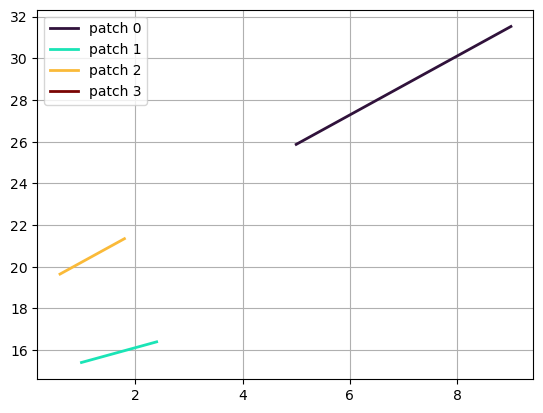

In [26]:
slp = slps[-1]

tau = 6.4
chi = np.linspace(0, 20, 101)
lam = slp.get_elevation_patches(tau, chi)

print(f'lam.shape = {lam.shape}')

for i, ilam in enumerate(lam):
    plt.plot(chi, ilam, label=f'patch {i}', color=colors[i], linewidth=2)
plt.legend()
plt.grid(True)
plt.show()
    

In [27]:
slp.get_elevation_starts(tau)

array([25.6, 15.4, 19.6, 18.4])

In [28]:
max(3, 4)

4

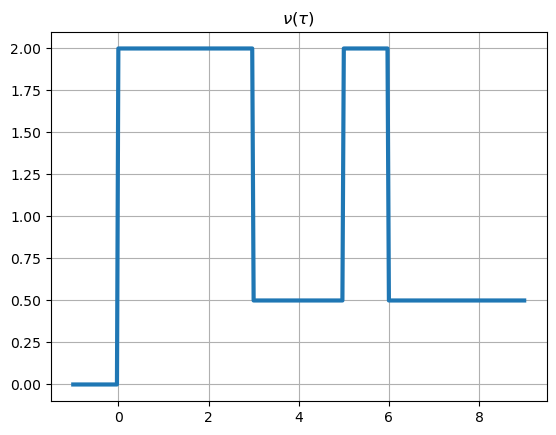

In [29]:
tau = np.linspace(-1, 9, 321)

slp = slps[-1]
plt.title(r'$\nu(\tau)$')
plt.plot(tau, slp.get_uplift_rate(tau), linewidth=3)
plt.grid(True)
plt.show()

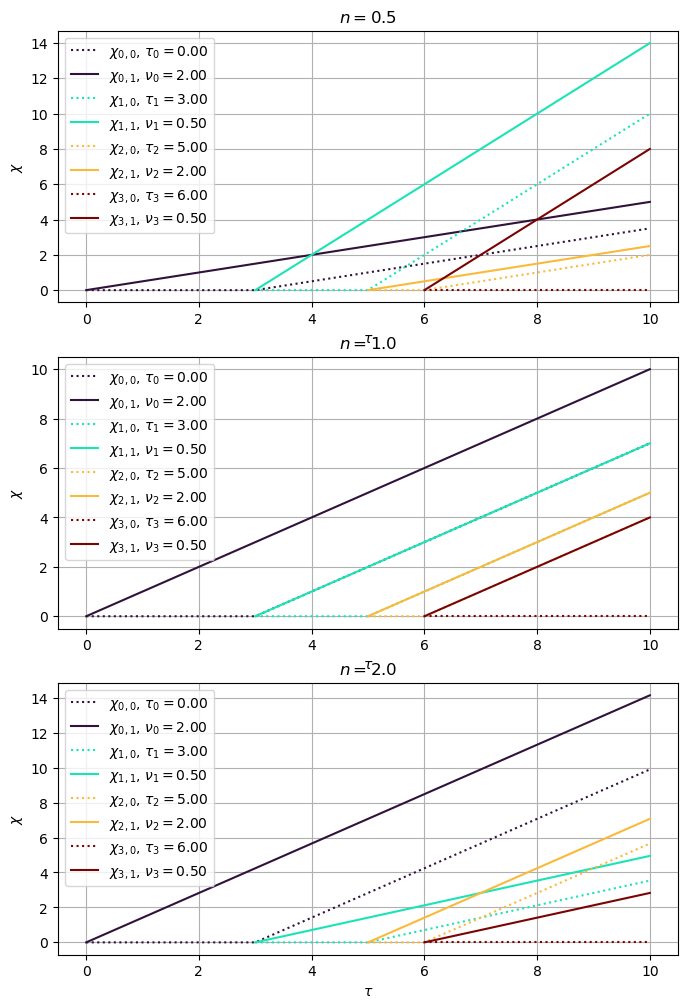

In [30]:
tau = np.linspace(0, 10, 21)

fig, axs = plt.subplots(len(slps))
fig.set_figwidth(8)
fig.set_figheight(12)


for j, slp in enumerate(slps):
    chi_lines1 = slp.get_horizontal_starts(tau)
    chi_lines0 = chi_lines1 - slp.get_horizontal_lengths().reshape([len(patch_starts), 1])
    chi_lines0[chi_lines0 < 0] = 0

    for i in range(len(chi_lines1)):
        chi_line0 = chi_lines0[i]
        chi_line1 = chi_lines1[i]
        axs[j].plot(tau, chi_line0, color=colors[i], linestyle=':', linewidth=1.5, 
                    label=r"$\chi_{{{0}, {1}}}$, $\tau_{{{0}}} = {2:.2f}$".format(i, 0, slp.patch_starts[i]))
        axs[j].plot(tau, chi_line1, color=colors[i], linestyle='-', linewidth=1.5, 
                    label=r"$\chi_{{{0}, {1}}}$, $\nu_{{{0}}} = {2:.2f}$".format(i, 1, slp.uplift_rates[i]))

    axs[j].set_xlabel(r'$\tau$')
    axs[j].set_ylabel(r'$\chi$')
    
    axs[j].set_title(f'$n = {slp.n}$')
    axs[j].grid(True)
    axs[j].legend()

plt.show()

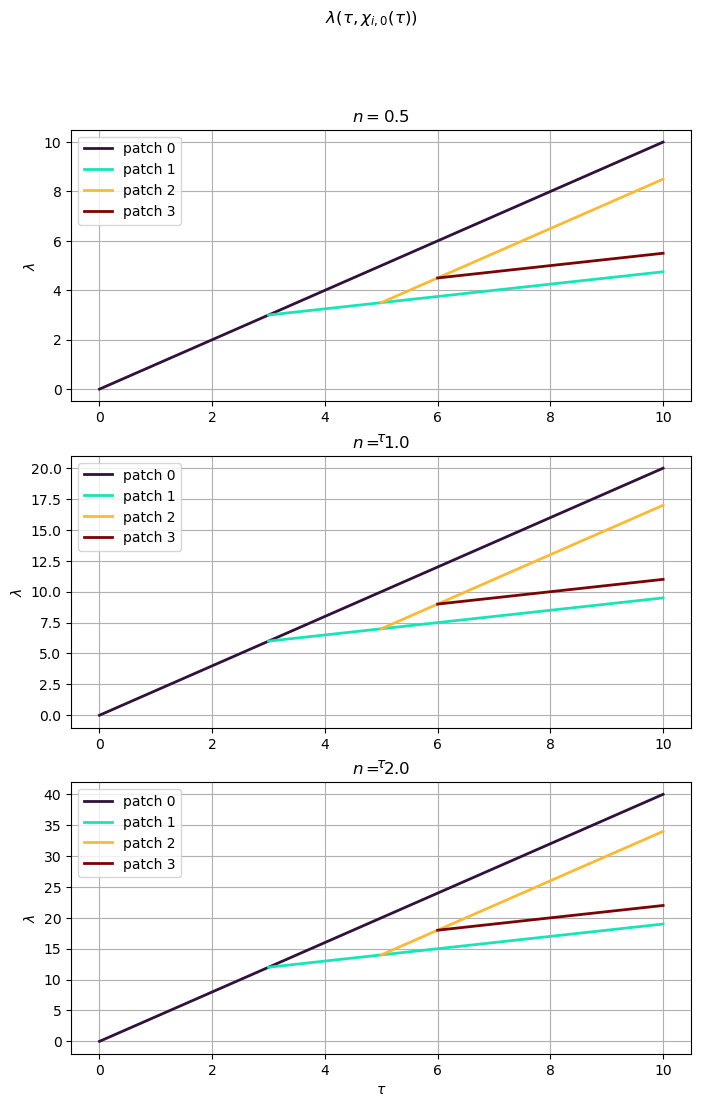

In [31]:
tau = np.linspace(0, 10, 21)

fig, axs = plt.subplots(len(slps))
fig.set_figwidth(8)
fig.set_figheight(12)

fig.suptitle(r'$\lambda(\tau, \chi_{i, 0}(\tau))$')

for j, slp in enumerate(slps):

    lams = slp.get_elevation_starts(tau)
    for i, lam in enumerate(lams):
        axs[j].plot(tau, lam, color=colors[i], linewidth=2, label=f'patch {i}')
    
    axs[j].set_xlabel(r'$\tau$')
    axs[j].set_ylabel(r'$\lambda$')
    
    axs[j].set_title(f'$n = {slp.n}$')
    axs[j].grid(True)
    axs[j].legend()

plt.show()

/usr/lib64/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1187: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/usr/lib64/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1188: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/usr/lib64/python3.11/site-packages/mpl_toolkits/mplot3d/proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


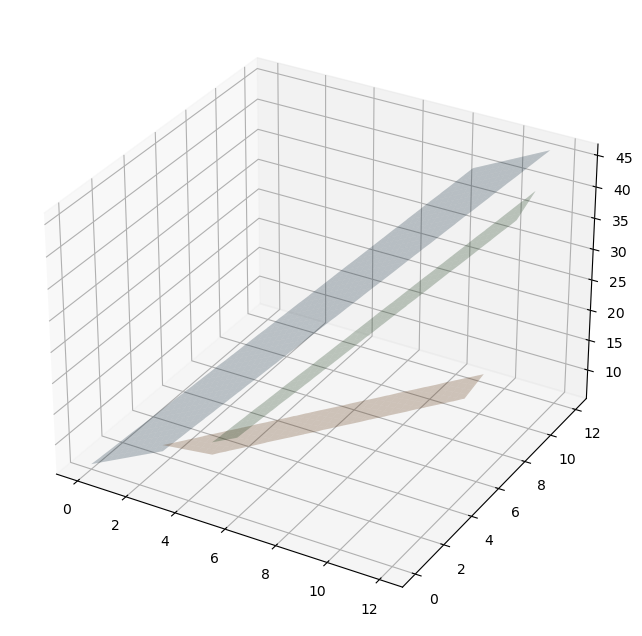

In [32]:
tau = np.linspace(0, 12, 601)
chi = np.linspace(0, 12, 601)

tau_space = np.ones([len(tau), len(chi)])*tau.reshape([len(tau), 1])
chi_space = np.ones([len(tau), len(chi)])*chi.reshape([1, len(chi)])

lam_space = slp.get_elevation_patches(tau_space, chi_space)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figheight(8)
fig.set_figwidth(10)

for i in range(len(lam_space)):
    ax.plot_surface(tau_space, chi_space, lam_space[i], alpha=0.25)

In [33]:
tau = np.linspace(0, 12, 301)
chi = np.linspace(0, 12, 601)

tau_space = np.ones([len(tau), len(chi)])*tau.reshape([len(tau), 1])
chi_space = np.ones([len(tau), len(chi)])*chi.reshape([1, len(chi)])

lam_spaces = np.array([slp.get_elevation_patches(tau_space, chi_space) for slp in slps])

images = []

with tqdm(total=len(tau)) as pbar:
    for itau, tau in enumerate(tau):
        fig, axs = plt.subplots(len(slps))
        fig.set_figwidth(8)
        fig.set_figheight(12)

        fig.suptitle(r'$\tau = {0:.4f}$'.format(tau))
        
        for islp, slp in enumerate(slps):
            axs[islp].set_title('$n = {0}$'.format(slp.n))
        
            lam = lam_spaces[islp, :, itau, :]
            for i, ilam in enumerate(lam):
                axs[islp].plot(chi, ilam, label=f'patch {i}', color=colors[i], linewidth=2)
            axs[islp].legend()
            axs[islp].grid(True)
            axs[islp].set_xlabel(r'$\chi$')
            axs[islp].set_ylabel(r'$\lambda$')
        fig.canvas.draw()
        images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
        fig.clear()
        plt.close('all')
        del fig
        
        pbar.update()

filename = 'gifs/patches.gif'
io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/301 [00:00<?, ?it/s]

generated and saved to path gifs/patches.gif
